# Домашняя работа

В этой работе вам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у вас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

Что необходимо обсудить до начала работы?
 
*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться... 

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Но на одном из семинаров мы кодировали побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE - очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма

Мы уверены, что вы научились гуглить и искать полезные материалы в интернете, когда делали домашнее задание по YOLO, поэтому в этот раз просто покажем один из способов, как это можно сделать и затем в своих проектах вы можете брать этот подход и, возможно, как-то улучшать его!

Тем кому очень интересно, как же все работает - заходите в файл vocab.py, очень советуем!

In [101]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:05<00:00, 1524.95it/s]


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [102]:
import numpy as np

In [103]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')
    print('d_inp:', dev_inp[i])
    print('d_out:', dev_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

d_inp: в распоряжении гостей общая кухня и общая гостиная .
d_out: a shared equipped kitchen and a common living room are provided to guests .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

d_inp: на территории виллы sh@@ eng@@ si hu@@ a@@ jing находится сад и терраса .
d_out: at sh@@ eng@@ si hua@@ jing villa you will find a garden and a terrace .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .

d_inp: расстояние от отеля li@@ bu@@ š@@ e до ближайшей станции метро ko@@ by@@ lis@@ y ( линия с ), от которой можно добраться до центрального железнодорожного вокзала праги и центра го

In [104]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [105]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


## За вас сделали домашнюю работу? Нет, вам самое интересное!

Если вы пролистываете ноутбук и вам уже очень хочется начать писать самим - то мы вас понимаем, задание очень интересное и полезное! 
И спешим вас обрадовать, так как вы дождались и тут как раз можно проявить всю фантазию и мастерство написание нейронных сетей!


###  Задание 1 (1 балла)
В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще. Вы можете редактировать его под себя: добавлять новые методы, новые переменные, писать на pytorch ligtning и другое.

Главное - сохраните идею шаблона и сделайте его очень удобным, так как с ним еще предстоит работать!

Заполните пропуски с `<YOUR CODE HERE>`

Во время выполнения польззовался статьей, в которой решалась задача на tensorflow
URL: https://cjlise.github.io/machine-learning/Neural-Machine-Translation-Attention/

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [107]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        prev_gru0_state = prev_state[0]
        output_emb = self.emb_out(prev_tokens)
        
        
        new_dec_state = self.dec0(output_emb, prev_gru0_state)
        nd = new_dec_state
        output_logits = self.logits(nd)
        
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
         
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [108]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)



h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))



assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0][0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)

assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)

assert logits_seq2.shape == logits_seq.shape

In [109]:
print(train_inp[:3])

['на территории обустроена бесплатная частная парковка .'
 'кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .'
 'отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .']


In [110]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
lazarev@@ sala village heaven vila vineyards eco 9 9 terre zem@@ hour zag@@ trabzon inese eggs hillside ún dge ential 1@@ st@@ sen@@ sh@@ explo@@
lazarev@@ dish prac@@ maine mouth futon pets hana prat playa millen@@ ust@@ nish@@ 8 who who cream ina selec@@ mum@@ salt ad@@ linens fashion krasnoyarsk
lazarev@@ marqu@@ cd riya domaine locally lec@@ savior turkish nas@@ ree zam@@ nas@@ neighbor@@ ž doors и dae 30@@ 30@@ vine attan gado riverfront wharf


### Задание 2 (2 балла)

Тут нечего объяснять, нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг 

In [111]:
def loss_function(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учиттывать последующие
    * разделить loss на длину вхходящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)
    
    
    # log-probabilities всех токеноы на всех шагах
    logprobs_seq =  (-torch.log_softmax(logits_seq, dim=-1)) # [batch_size, out_len, num_tokens]
    
    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # [batch_size, out_len]
    # нужно обойтись только векторными операциями без for

    # cross-entropy по всем токенам где mask == True
    
    return (torch.sum(logp_out * mask)) / torch.sum(model.inp_voc.compute_mask(inp)).to(torch.float32) # тут должен получиться скаляр!

In [112]:


dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5945, device='cuda:0', grad_fn=<DivBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [113]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU. Вы можете изменять вход и выход, 
    как вам удобно, главное оставьте логику ее подсчета!!!
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, max_len=25, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [114]:
compute_bleu(model, dev_inp, dev_out)

0.0075778634900456054

### Training loop (1 балл)

Нужно просто написать цикл обучения и подсчитать метрики! И пройти assert по качеству

In [115]:

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32


        

In [116]:
print(train_inp[0])
train_out[0]

на территории обустроена бесплатная частная парковка .


'free private parking is available on site .'

In [117]:
num_iter = 10_000
for i in tqdm(range(num_iter)):
    step = len(metrics['train_loss']) + 1
    batch_ind = np.random.randint(len(train_inp), size=batch_size)
    

    
    input_batch = inp_voc.to_matrix(train_inp[batch_ind]).to(device)
                  
    out_batch = out_voc.to_matrix(train_out[batch_ind]).to(device)

    
    loss = loss_function(model, input_batch, out_batch)
    metrics['train_loss'].append(float(loss))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
   
    
    if i % 250 == 0:
        with torch.no_grad():
            blue = compute_bleu(model, dev_inp, dev_out)
            metrics['dev_bleu'].append(float(blue))
            #print(blue)

100%|██████████| 10000/10000 [03:26<00:00, 48.44it/s]


In [118]:
compute_bleu(model, dev_inp, dev_out)

17.087402352026018

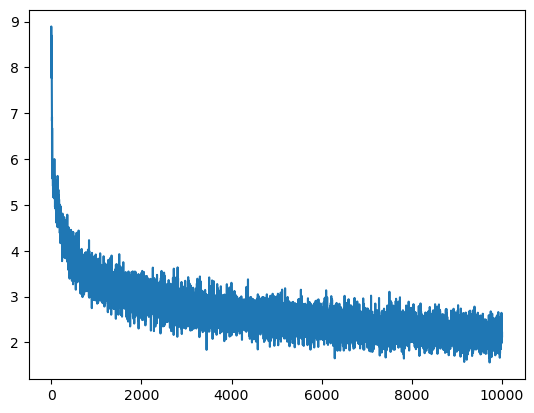

In [119]:


plt.plot(metrics['train_loss'])
plt.show()

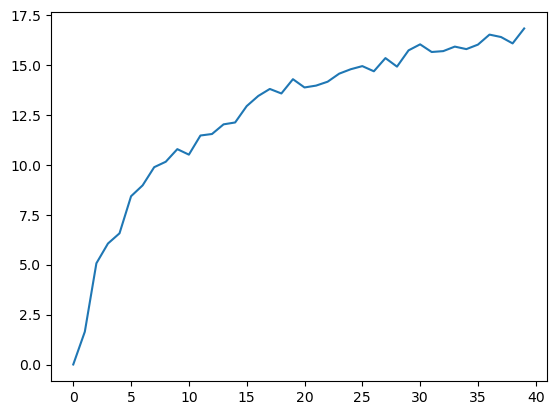

In [120]:
a = metrics['dev_bleu']
plt.plot(a)
plt.show()

In [121]:
a = metrics['dev_bleu']
a = a[len(a) - 11:len(a) - 1]
a = np.array(a)


In [122]:
assert a.mean() > 15, "Ты можешь больше! попробуй еще раз)" # немного поменял ассерт, но смысл тот же

In [123]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests can cook in the shared kitchen and shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
other facilities offered include free parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the town of america is 25 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in the centre of the black sea , the black sea beach is a 5 - minute walk from the beach and a 5 - minute walk from the beach .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located in the centre of saint petersburg , this apartment features a private balcony with views of the city .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the private bathroom comes with a shower and

## Attention is all you need

### Задание 3

В этом разделе мы хотим, чтобы вы усовершенствовали базовую модель


Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов: 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [124]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size
        
        self.e = nn.Parameter(torch.ones(self.hid_size, self.hid_size), requires_grad=True)
        self.d = nn.Parameter(torch.ones((self.hid_size, self.hid_size)), requires_grad=True)
        self.out = nn.Parameter(torch.ones((self.hid_size, 1)), requires_grad=True)

        self.tanh = nn.Tanh()
        # опишите все слои, которые нужны Attention
        

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """
        softmax = nn.Softmax(1)
        # считаем логиты
        dec_with_time = torch.unsqueeze(dec, 1)
        logits = torch.matmul(self.tanh(torch.matmul(enc,self.e) +
                                         torch.matmul(dec_with_time, self.d)), self.out.view(128,1))
        
        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        trashhold = -1e9 * torch.ones_like(logits)
        logits = torch.where(torch.unsqueeze(inp_mask, -1), logits, trashhold)
        # Примените softmax
        probs = softmax(logits)

        # Подсчитайте выход attention используя enc состояния и вероятностями
        attn = torch.sum(probs * enc, axis = 1)
        
        probs = torch.reshape(probs, [inp_mask.shape[0],-1])

        return attn, probs

### Seq2seq model with attention (2 points)

Теперь вы можете использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используйте предыдущее состояние декодера, и написанный слой Attention




In [125]:
class AttentiveModel(BaseModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """Переводчик с Attention"""
        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        # initialize layers
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attn = AttentionLayer(len(inp_voc), len(out_voc), attn_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        self.dec_start = nn.Linear(hid_size, hid_size)

    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """
        
        # делаем encode
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        mask = model.inp_voc.compute_mask(inp)
        

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        outputs = np.stack(enc_seq.cpu().detach().numpy(), axis = 0)
        outputs = torch.from_numpy(outputs).to(device)
        
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state).to(device)
        attn_val, first_attn_probas = self.attn(outputs, dec_start, mask)
        
        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention
        
        first_state = [dec_start, outputs, mask, attn_val, first_attn_probas]
        
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """
        
        out_emb = self.emb_out(prev_tokens)
        attn_val = prev_state[3]
        
        
        out_emb = torch.concat([out_emb, attn_val], dim=-1)

        
        out_dec = self.dec0(out_emb, prev_state[0])
        
        output_logits = self.logits(out_dec)

        
        attn_val, attn_prob = self.attn(prev_state[1], out_dec, prev_state[2])
        

        new_dec_state = [out_dec, prev_state[1], prev_state[2],  attn_val, attn_prob]
        
        return new_dec_state, output_logits


### Обучение модели (1 points)

Нужно обучить AttentiveModel и пройти assert по качеству

In [126]:

metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
batch_size = 32

In [128]:
num_iter = 25000
for i in tqdm(range(num_iter)):
    
    batch_ind = np.random.randint(len(train_inp), size=batch_size)
    

    
    input_batch = inp_voc.to_matrix(train_inp[batch_ind]).to(device)
                  
    out_batch = out_voc.to_matrix(train_out[batch_ind]).to(device)

    
    loss = loss_function(model, input_batch, out_batch)
    metrics['train_loss'].append(float(loss))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
   
    
    if i % 250 == 0:
       
        with torch.no_grad():
            blue = compute_bleu(model, dev_inp, dev_out)
            metrics['dev_bleu'].append(float(blue))
           

100%|██████████| 25000/25000 [20:01<00:00, 20.80it/s]


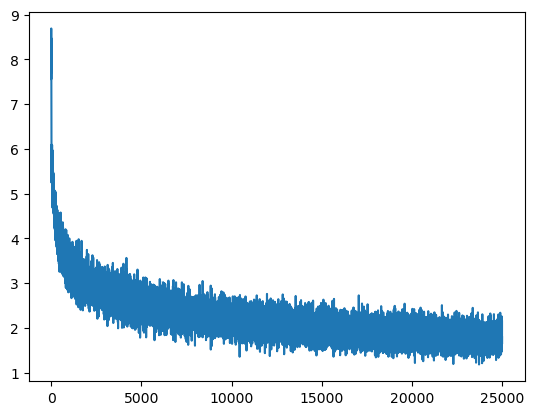

In [ ]:
plt.plot(metrics['train_loss'])
plt.show()

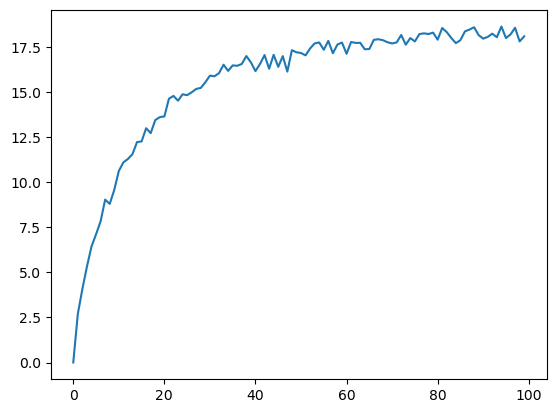

In [ ]:
a = metrics['dev_bleu']
plt.plot(a)
plt.show()

In [ ]:

#  
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 23, "Ты можешь больше! попробуй еще раз)"y

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests can use a shared kitchen facilities at their disposal .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental and free parking are available on request .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
leu@@ ca is 9 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in the centre of the beach , this apartment features a garden with a terrace , a terrace and a private beach area .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
the apartment is a self - catering accommodation located in prague , 200 metres from the o2 arena .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private bathroom also comes with towels .



## Как решать NLP задачу? Дообучить модель из huggingface

Как мы видели на последнем семинаре в прошлом модуле можно получить отлично качество генерации текста, написав при этом не очень много строк кода, может быть попробовать тут также?)

Это отличная идея!

### Задание 4 (2 points)
 
Нужно взять модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучить на наших данных и посмотреть, какое качество

In [ ]:
data_inp = list(open('./train.bpe.ru').read().split('\n'))
data_out = list(open('./train.bpe.en').read().split('\n'))
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)


In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets.dataset_dict import DatasetDict
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en")

translator = pipeline('translation_ru_to_en', model="Helsinki-NLP/opus-mt-ru-en")
res = translator(train_inp[0])
print(train_inp[0])
print(res)
#train_encodings = tokenizer(train_inp, truncation=True, padding=True)
#val_enc = tokenizer(dev_inp, truncation=True, padding=True)

  

на территории обустроена бесплатная частная парковка .
[{'translation_text': 'The Territory has a free private parking area.'}]


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

c:\Users\artem\anaconda3\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\artem\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
from datasets import Dataset
from datasets.dataset_dict import DatasetDict

d = DatasetDict({'train':Dataset.from_dict({'ru':train_inp,'en':train_out}),
                 'test':Dataset.from_dict({'ru':dev_inp, 'en':dev_out})
                 })


In [ ]:
d

DatasetDict({
    train: Dataset({
        features: ['ru', 'en'],
        num_rows: 47001
    })
    test: Dataset({
        features: ['ru', 'en'],
        num_rows: 3000
    })
})

In [ ]:
print(d['train']['ru'][0])
d['train']['en'][0]


на территории обустроена бесплатная частная парковка .


'free private parking is available on site .'

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
import evaluate
metric = evaluate.load("sacrebleu")

In [ ]:
d['train'][172]['ru']

'в местах общего пользования предоставляется бесплатный wi - fi .'

In [ ]:
#https://huggingface.co/learn/nlp-course/chapter7/4?fw=tf
en_sentence = d["train"][1]["ru"]
fr_sentence = d["train"][1]["en"]

inputs = tokenizer(en_sentence, text_target=fr_sentence)
inputs

{'input_ids': [49, 23946, 31341, 31096, 48140, 36741, 49, 40639, 31096, 49005, 31096, 49, 2, 49, 48737, 177, 49, 48140, 21723, 31451, 34311, 40639, 25598, 48939, 49, 48939, 31096, 46335, 48970, 49026, 48968, 49, 31341, 25598, 49026, 31096, 40639, 25598, 48957, 40639, 49, 48140, 31451, 31096, 49005, 31096, 49033, 21723, 18482, 42465, 36741, 31451, 31451, 48968, 36741, 49, 49026, 25598, 31341, 48968, 49, 21723, 49, 31341, 36741, 18482, 40639, 31096, 31341, 25598, 31451, 48968, 250, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [9546, 82, 9, 115, 611, 111, 940, 133, 9800, 10, 5672, 42, 190, 15, 177, 41, 4632, 13700, 11818, 250, 0]}

In [ ]:
max_length = 128
#https://huggingface.co/learn/nlp-course/chapter7/4?fw=tf

def preprocess_function(examples):
    inputs = [ex for ex in examples["ru"]]
    targets = [ex for ex in examples["en"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

In [ ]:
tokenized_datasets = d.map(
    preprocess_function,
    batched=True,
    remove_columns=d["train"].column_names,
)

Map:   0%|          | 0/47001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
# дальше в статье пошла какая-то шляпа с переходом с pytorch на tensorflow, 
#разобраться я к сожалению не успел

ImportError: 
TFAutoModelForSeq2SeqLM requires the TensorFlow library but it was not found in your environment.
However, we were able to find a PyTorch installation. PyTorch classes do not begin
with "TF", but are otherwise identically named to our TF classes.
If you want to use PyTorch, please use those classes instead!

If you really do want to use TensorFlow, please follow the instructions on the
installation page https://www.tensorflow.org/install that match your environment.


In [ ]:
<YOUR CODE HERE: compute_bleu>
# аналогично прошлым пунктам

assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 27, "Ты можешь больше! попробуй еще раз)"